In [1]:
# if jupyterlab:
%matplotlib widget
# if jupyter notebook:
# %matplotlib notebook

import torch
import numpy as np 
import matplotlib.pyplot as plt
from skimage.util import montage
from recoMRD import recoMRD
from bart import bart

def plot_mosaic(img:np.ndarray, cmap='turbo', clim=None, grid_shape=None, title=None, transpose=False):
    img = np.squeeze(np.abs(img)) 
    if img.ndim > 3:
        print(f'Error! plot_mosaic expects 3D data but it is {img.ndim}D')
        return
    img = np.moveaxis(img,-1,0)
    img = montage(img, fill=0, grid_shape=grid_shape)
    if transpose:
        img = img.T
    
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation='nearest', clim=clim)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.colorbar()
    plt.tight_layout() 
    return img

def plot3D(img:np.ndarray, cmap='turbo', clim=None, pos = None):
    img = img.squeeze()
    if pos is None:
        pos = [x//2 for x in img.shape[0:3]]
        
    plt.figure()
    plt.subplot(131)
    plt.imshow(img[:,:,pos[2]], cmap=cmap, interpolation='nearest', origin='lower',clim=clim)
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(img[:,pos[1],:], cmap=cmap, interpolation='nearest', origin='lower',clim=clim)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(img[pos[0],:,:], cmap=cmap, interpolation='nearest', origin='lower',clim=clim)
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout() 

In [2]:
filename = './../example_data/meas_MID00024_FID04971_localizer3D_iPAT2.mrd'
mrd = recoMRD(filename)

kspace_osremoved = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
img_sos = mrd.coil_combination(kspace_osremoved, method='sos')

MRD file has more than one group. The last group will be imported.
Number of reference scans: 432
Number of image     scans: 1998
k-space size in protocol: 448 x 224 x 18
image   size in protocol: 224 x 224 x 18
k-space encoding size (224 x 18) differs from max encoding step (223 x 18)
This can be due to parallel imaging, partial Fourier, etc.
Acceleration factor: 2 x 1
Reference scan type: integrated
Existing scans: acs, noise, image_scan.
Fully sampled array size=[16, 448, 224, 18, 1, 1, 1, 1, 1, 1, 1]


Filling acs       , size=[16, 448, 24, 18, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 432/432 [00:00<00:00, 11989.67it/s]
Filling noise     , size=[16, 448, 1, 1, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 1/1 [00:00<00:00, 2376.38it/s]
Filling image_scan, size=[16, 448, 111, 18, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 1998/1998 [00:00<00:00, 8118.27it/s]


Removing oversampling...
Done.
Combining coils (sos)... 


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 237.36it/s]


3.0994415283203125e-06
Done.


/kyb/agks/aaghaeifar/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


torch.Size([1, 224, 224, 18, 1, 1, 1, 1, 1, 1, 1])


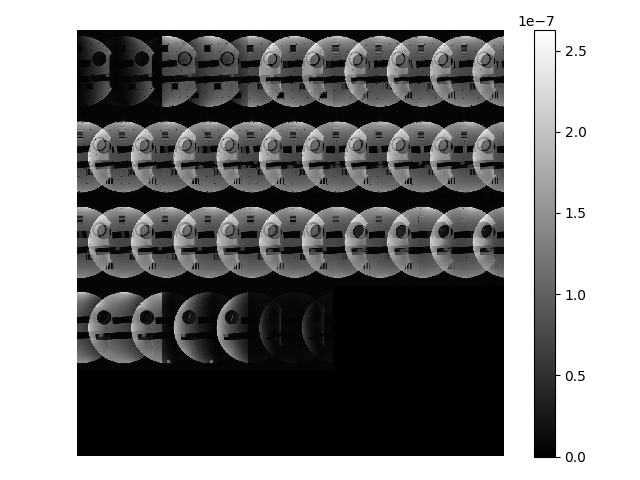

In [3]:
# sum of square reco
print(img_sos.shape)
temp = plot_mosaic(img_sos.numpy(), cmap='gray')

(448, 224, 18)
Acceleration Factor: R=2.02


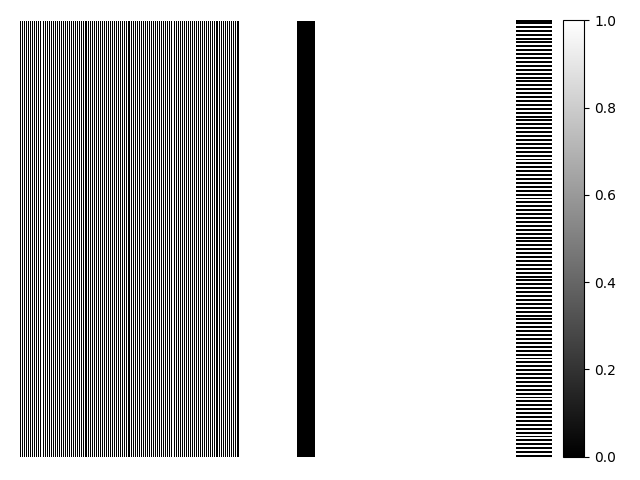

In [4]:
# show sampling pattern
temp = mrd.kspace['image_scan'].select(0, mrd.dim_info['cha']['ind']).squeeze().numpy() # take the first coil
mask = bart.bart(1, 'pattern', temp).real > 0
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
plot3D(mask, clim=[0, 1], cmap='gray')
print('Acceleration Factor: R={:.2f}'.format(R))

(448, 224, 16)


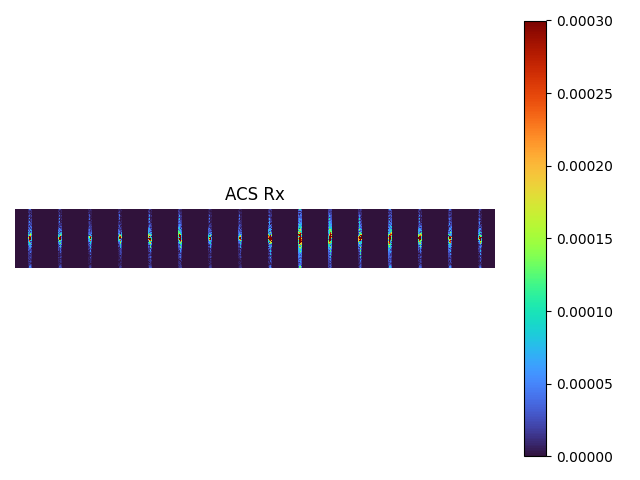

In [5]:
# show some Rx channels from reference scan
pe2  = mrd.dim_info['pe2']
temp = mrd.kspace['acs'].index_select(pe2['ind'], torch.Tensor([pe2['len']//2]).int()).moveaxis(mrd.dim_info['cha']['ind'], -1).abs().squeeze().numpy()
print(temp.shape)
temp = plot_mosaic(temp, grid_shape = [1, temp.shape[2]], clim=[0, 3e-4], title='ACS Rx')

Removing oversampling...
Done.
Combining coils (sos)... 


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 255.86it/s]

4.0531158447265625e-06
Done.
torch.Size([1, 224, 224, 18, 1, 1, 1, 1, 1, 1, 1])
torch.Size([224, 224, 18])


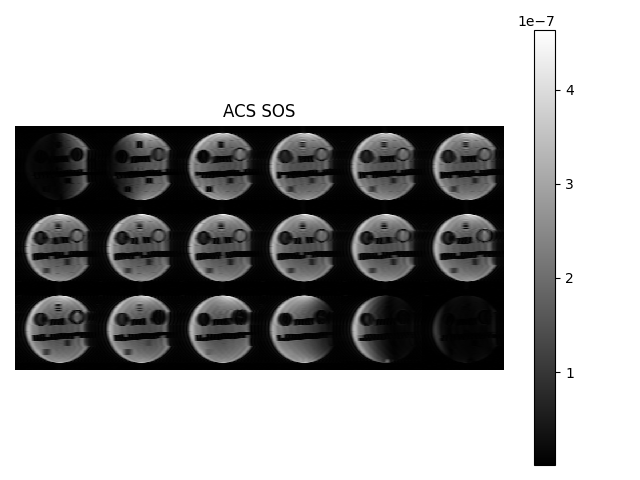

In [6]:
# sum of square of reference scan
acs = mrd.remove_oversampling(mrd.kspace['acs'], is_kspace=True)
acs_img = mrd.coil_combination(acs, method='sos')

temp = acs_img.squeeze()
print(acs_img.shape)
print(temp.shape)
temp = plot_mosaic(temp.numpy(), grid_shape = [3, temp.shape[2]//3], cmap='gray', title='ACS SOS')


In [7]:
%%time
# calculate coil sensitivity, using espirit method
coils_sensitivity_espirit = mrd.calc_coil_sensitivity(acs, method='espirit')
print(coils_sensitivity_espirit.shape)

Computing coil sensitivity...
Done.
Done.
torch.Size([16, 224, 224, 18, 1, 1, 1, 1, 1, 1, 1])
CPU times: user 437 ms, sys: 685 ms, total: 1.12 s
Wall time: 1min 41s


In [8]:
%%time
# use caldir method to get coil sensitivity 
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(acs, method='caldir')
print(coils_sensitivity_caldir.shape)

Computing coil sensitivity...
Calibration region 112x24x18
Done.
Done.
torch.Size([16, 224, 224, 18, 1, 1, 1, 1, 1, 1, 1])
CPU times: user 514 ms, sys: 638 ms, total: 1.15 s
Wall time: 1.2 s


torch.Size([32, 224, 224, 1, 1, 1, 1, 1, 1, 1, 1])
(224, 224, 32)


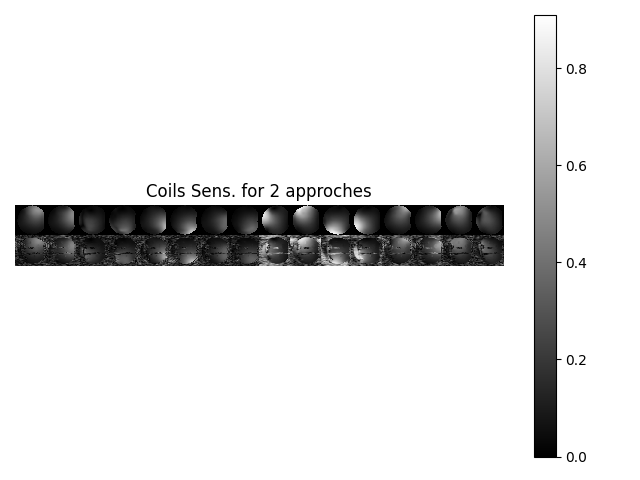

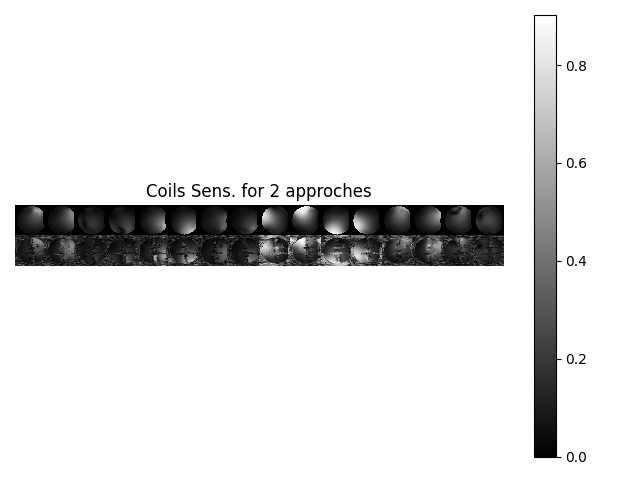

In [9]:
temp = torch.cat((coils_sensitivity_espirit, coils_sensitivity_caldir), dim = mrd.dim_info['cha']['ind']).index_select(mrd.dim_info['pe2']['ind'], torch.Tensor([0]).int()).abs()
print(temp.shape)
temp = temp.moveaxis(mrd.dim_info['cha']['ind'], -1).squeeze().numpy()
print(temp.shape)
temp = plot_mosaic(temp, grid_shape = [2, temp.shape[2]//2], cmap='gray', title='Coils Sens. for 2 approches')

temp = torch.cat((coils_sensitivity_espirit, coils_sensitivity_caldir), dim = mrd.dim_info['cha']['ind']).index_select(mrd.dim_info['pe2']['ind'], torch.Tensor([mrd.dim_info['pe2']['len']-1]).int()).abs()
temp = temp.moveaxis(mrd.dim_info['cha']['ind'], -1).squeeze().numpy()
temp = plot_mosaic(temp, grid_shape = [2, temp.shape[2]//2], cmap='gray', title='Coils Sens. for 2 approches')

Removing oversampling...
Done.
Combining coils (bart)... 


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 250.30it/s]


GPU reconstruction
Size: 903168 Samples: 447552 Acc: 2.02
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.395252
1.898514747619629
Done.
Combining coils (bart)... 


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 318.71it/s]


GPU reconstruction
Size: 903168 Samples: 447552 Acc: 2.02
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.361687
1.8404428958892822
Done.
(224, 224, 36)


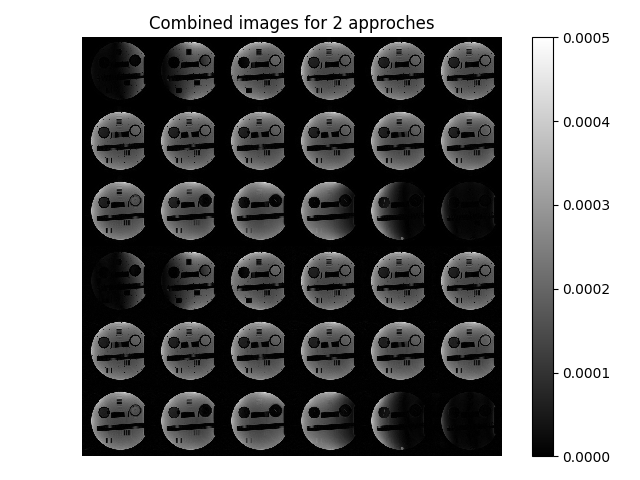

In [10]:
img = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
volume_comb_espirit = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_espirit)
volume_comb_caldir  = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_caldir)
temp = torch.cat((volume_comb_espirit, volume_comb_caldir), dim = mrd.dim_info['pe2']['ind']).squeeze().abs().numpy()
print(temp.shape)
temp = plot_mosaic(temp, grid_shape = [6, temp.shape[2]//6], cmap='gray', clim = [0, 5e-4], transpose = False, title='Combined images for 2 approches')

